# Machine Learning for Unstructured Text

```by Igor Ostaptchenko AKA igor_ost@wayne.edu```

Use LSTM to learn the structure and generate the sequences of text. The learned probabilities of characters allows to continue the text:
if the random line has ends with three latters from the main protagonist name the network is expected to correctly finish the name:
``` Mon...tag said,```

In [38]:
#import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from pprint import pprint

I used the classic nevella: Fahrenheit 451: Ray Bradbury.
The capitallization is preserved.

In [41]:
# load ascii text and covert to lowercase
filename = "FAHRENHEIT 451.txt"
raw_text = open(filename, 'r').read()
#raw_text = raw_text.lower()
print(raw_text[:2000])

FAHRENHEIT 451 by Ray Bradbury
This one, with gratitude, is for DON CONGDON.
FAHRENHEIT 451:
The temperature at which book-paper catches fire and burns
PART I
IT WAS A PLEASURE TO BURN
IT was a special pleasure to see things eaten, to see things blackened and changed. With the brass nozzle in his fists, with this great python spitting its venomous kerosene upon the world, the blood pounded in his head, and his hands were the hands of some amazing conductor playing all the symphonies of blazing and burning to bring down the tatters and charcoal ruins of history. With his symbolic helmet numbered 451 on his stolid head, and his eyes all orange flame with the thought of what came next, he flicked the igniter and the house jumped up in a gorging fire that burned the evening sky red and yellow and black. He strode in a swarm of fireflies. He wanted above all, like the old joke, to shove a marshmallow on a stick in the furnace, while the flapping pigeon-winged books died on the porch and law

The vocabulary is the list of all characters apperaing in the text.

In [18]:
# create mapping of unique chars to integers, and a reverse mapping
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
print(char_to_int)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, '`': 48, 'a': 49, 'b': 50, 'c': 51, 'd': 52, 'e': 53, 'f': 54, 'g': 55, 'h': 56, 'i': 57, 'j': 58, 'k': 59, 'l': 60, 'm': 61, 'n': 62, 'o': 63, 'p': 64, 'q': 65, 'r': 66, 's': 67, 't': 68, 'u': 69, 'v': 70, 'w': 71, 'x': 72, 'y': 73, 'z': 74}


In [19]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  251222
Total Vocab:  75


## Generate Sequences
Lets split data into sequences of 80. For each sequence the Y to be prediceted is the rest except one character 

In [20]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 80
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
  seq_in = raw_text[i:i + seq_length]
  seq_out = raw_text[i + seq_length]
  dataX.append([char_to_int[char] for char in seq_in])
  dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  251142


In [21]:
print(dataX[1])

[23, 30, 40, 27, 36, 30, 27, 31, 42, 1, 14, 15, 11, 1, 50, 73, 1, 40, 49, 73, 1, 24, 66, 49, 52, 50, 69, 66, 73, 0, 42, 56, 57, 67, 1, 63, 62, 53, 7, 1, 71, 57, 68, 56, 1, 55, 66, 49, 68, 57, 68, 69, 52, 53, 7, 1, 57, 67, 1, 54, 63, 66, 1, 26, 37, 36, 1, 25, 37, 36, 29, 26, 37, 36, 9, 0, 28, 23, 30, 40]


In [22]:
print(dataY[1])

27


In [23]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [26]:
# define the LSTM model
model = Sequential()
model.add(LSTM(512,input_shape=(X.shape[1], X.shape[2]), return_sequences=True)) 
#model.add(LSTM(512,input_shape=(X.shape[1], X.shape[2]))) 
model.add(Dropout(0.2))
model.add(LSTM(512))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam')
# define the checkpoint 
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-128->256.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# fit the model
model.fit(X, y, epochs=16, batch_size=8, callbacks=callbacks_list)

Epoch 1/16
31393/31393 [==============================] - ETA: 0s - loss: 2.6918
Epoch 00001: loss improved from inf to 2.69179, saving model to weights-improvement-01-2.6918-128->256.hdf5
31393/31393 [==============================] - 2084s 66ms/step - loss: 2.6918
Epoch 2/16
31393/31393 [==============================] - ETA: 0s - loss: 2.3032
Epoch 00002: loss improved from 2.69179 to 2.30315, saving model to weights-improvement-02-2.3032-128->256.hdf5
31393/31393 [==============================] - 2084s 66ms/step - loss: 2.3032
Epoch 3/16
31393/31393 [==============================] - ETA: 0s - loss: 2.0919
Epoch 00003: loss improved from 2.30315 to 2.09190, saving model to weights-improvement-03-2.0919-128->256.hdf5
31393/31393 [==============================] - 2084s 66ms/step - loss: 2.0919
Epoch 4/16
31393/31393 [==============================] - ETA: 0s - loss: 1.9552
Epoch 00004: loss improved from 2.09190 to 1.95522, saving model to weights-improvement-04-1.9552-128->256.hdf

I messed up file naming during multiple experiments: `weights-improvement-16-1.4586-128->256.hdf5` actually had to be named `weights-improvement-XX-XXX-512->512.hdf5`.
The trainig took ~10 hours on `Nvidia Quadro K4200`
```
io@io-MacPro:~/projects/secret/wsu/ie7860$ ll weights-improvement-*128*256.hdf5
-rw-r--r-- 1 root root 38326232 Apr 13 14:21 'weights-improvement-01-2.6918-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 14:56 'weights-improvement-02-2.3032-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 15:31 'weights-improvement-03-2.0919-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 16:05 'weights-improvement-04-1.9552-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 16:40 'weights-improvement-05-1.8578-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 17:15 'weights-improvement-06-1.7843-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 17:50 'weights-improvement-07-1.7242-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 18:24 'weights-improvement-08-1.6745-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 18:59 'weights-improvement-09-1.6333-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 19:34 'weights-improvement-10-1.5997-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 20:09 'weights-improvement-11-1.5661-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 20:43 'weights-improvement-12-1.5417-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 21:18 'weights-improvement-13-1.5153-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 21:53 'weights-improvement-14-1.4922-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 22:28 'weights-improvement-15-1.4759-128->256.hdf5'
-rw-r--r-- 1 root root 38326232 Apr 13 23:02 'weights-improvement-16-1.4586-128->256.hdf5'
io@io-MacPro:~/projects/secret/wsu/ie7860$ 
```
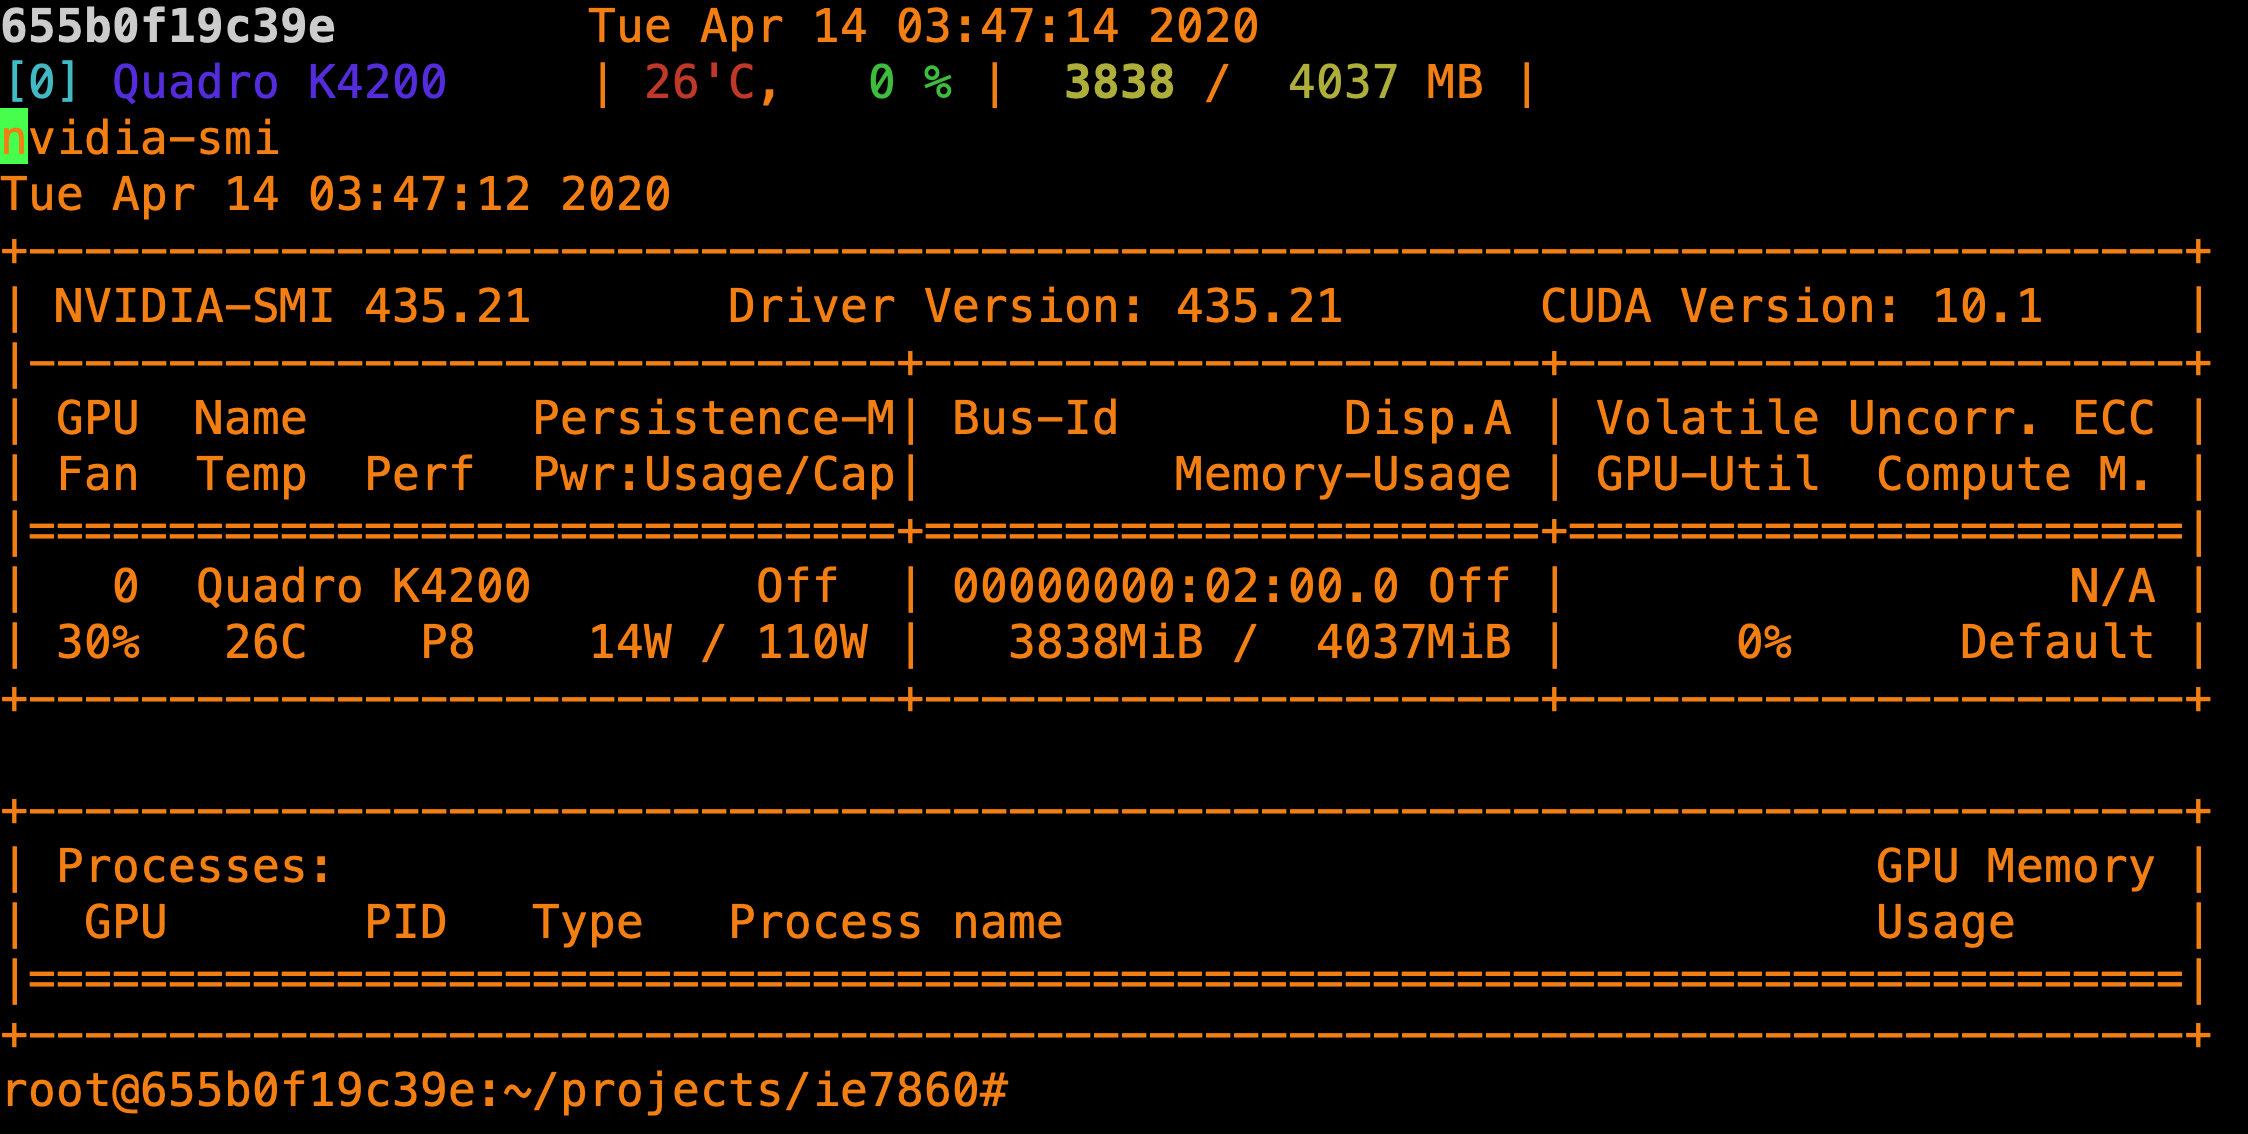

In [29]:
# load the network weights
filename = "weights-improvement-16-1.4586-128->256.hdf5" 
model.load_weights(filename) 
model.compile(loss='categorical_crossentropy', optimizer='adam')
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [34]:
import sys
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Randomly selected start line:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "...") # generate characters
for i in range(800):
  x = numpy.reshape(pattern, (1, len(pattern), 1))
  x = x / float(n_vocab)
  prediction = model.predict(x, verbose=0)
  index = numpy.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[value] for value in pattern]
  sys.stdout.write(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]
print("\nDone.")

Randomly selected start line:
"  And Clarisse. You never talked to her. I talked to her. And men like Beatty are ...
 and the words was not to be his face was the sound of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of t
Done.


The generated text looks like the real one. A new words were invented: `brru`. Notice how Caplalization is not present in the generated output. Perhaps because there are more lower case sequences.
Intersting that sequence started to repeatedly appear.

In [37]:
len(" and the words was not to be his face was the sound of the silence was so so brru and she was there in the middle of the silence")

128

In [35]:
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Randomly selected start line:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "...") # generate characters
for i in range(800):
  x = numpy.reshape(pattern, (1, len(pattern), 1))
  x = x / float(n_vocab)
  prediction = model.predict(x, verbose=0)
  index = numpy.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[value] for value in pattern]
  sys.stdout.write(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]
print("\nDone.")

Randomly selected start line:
" n a year ago when he had met an old man in the park and they had talked ....
Mon ...
tag said, "I want to sead an any forest and the people and the men who make a soom of the sound of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so so brru and she was there in the middle of the silence was so 
Done.


Here we see the correctly perdicted the tail of the name of the protagonist `Montag`:

```
Mon ...
tag said, "I want to sead an any forest and the people....
```

as well as correct syntax for stareting the qutation.

The training TAKES A LOT OF TIME. The LSTM also is prone to collapse unless I hit some bugs. It was sliding to Infinity in Loss on MacOS and AMD GPU:

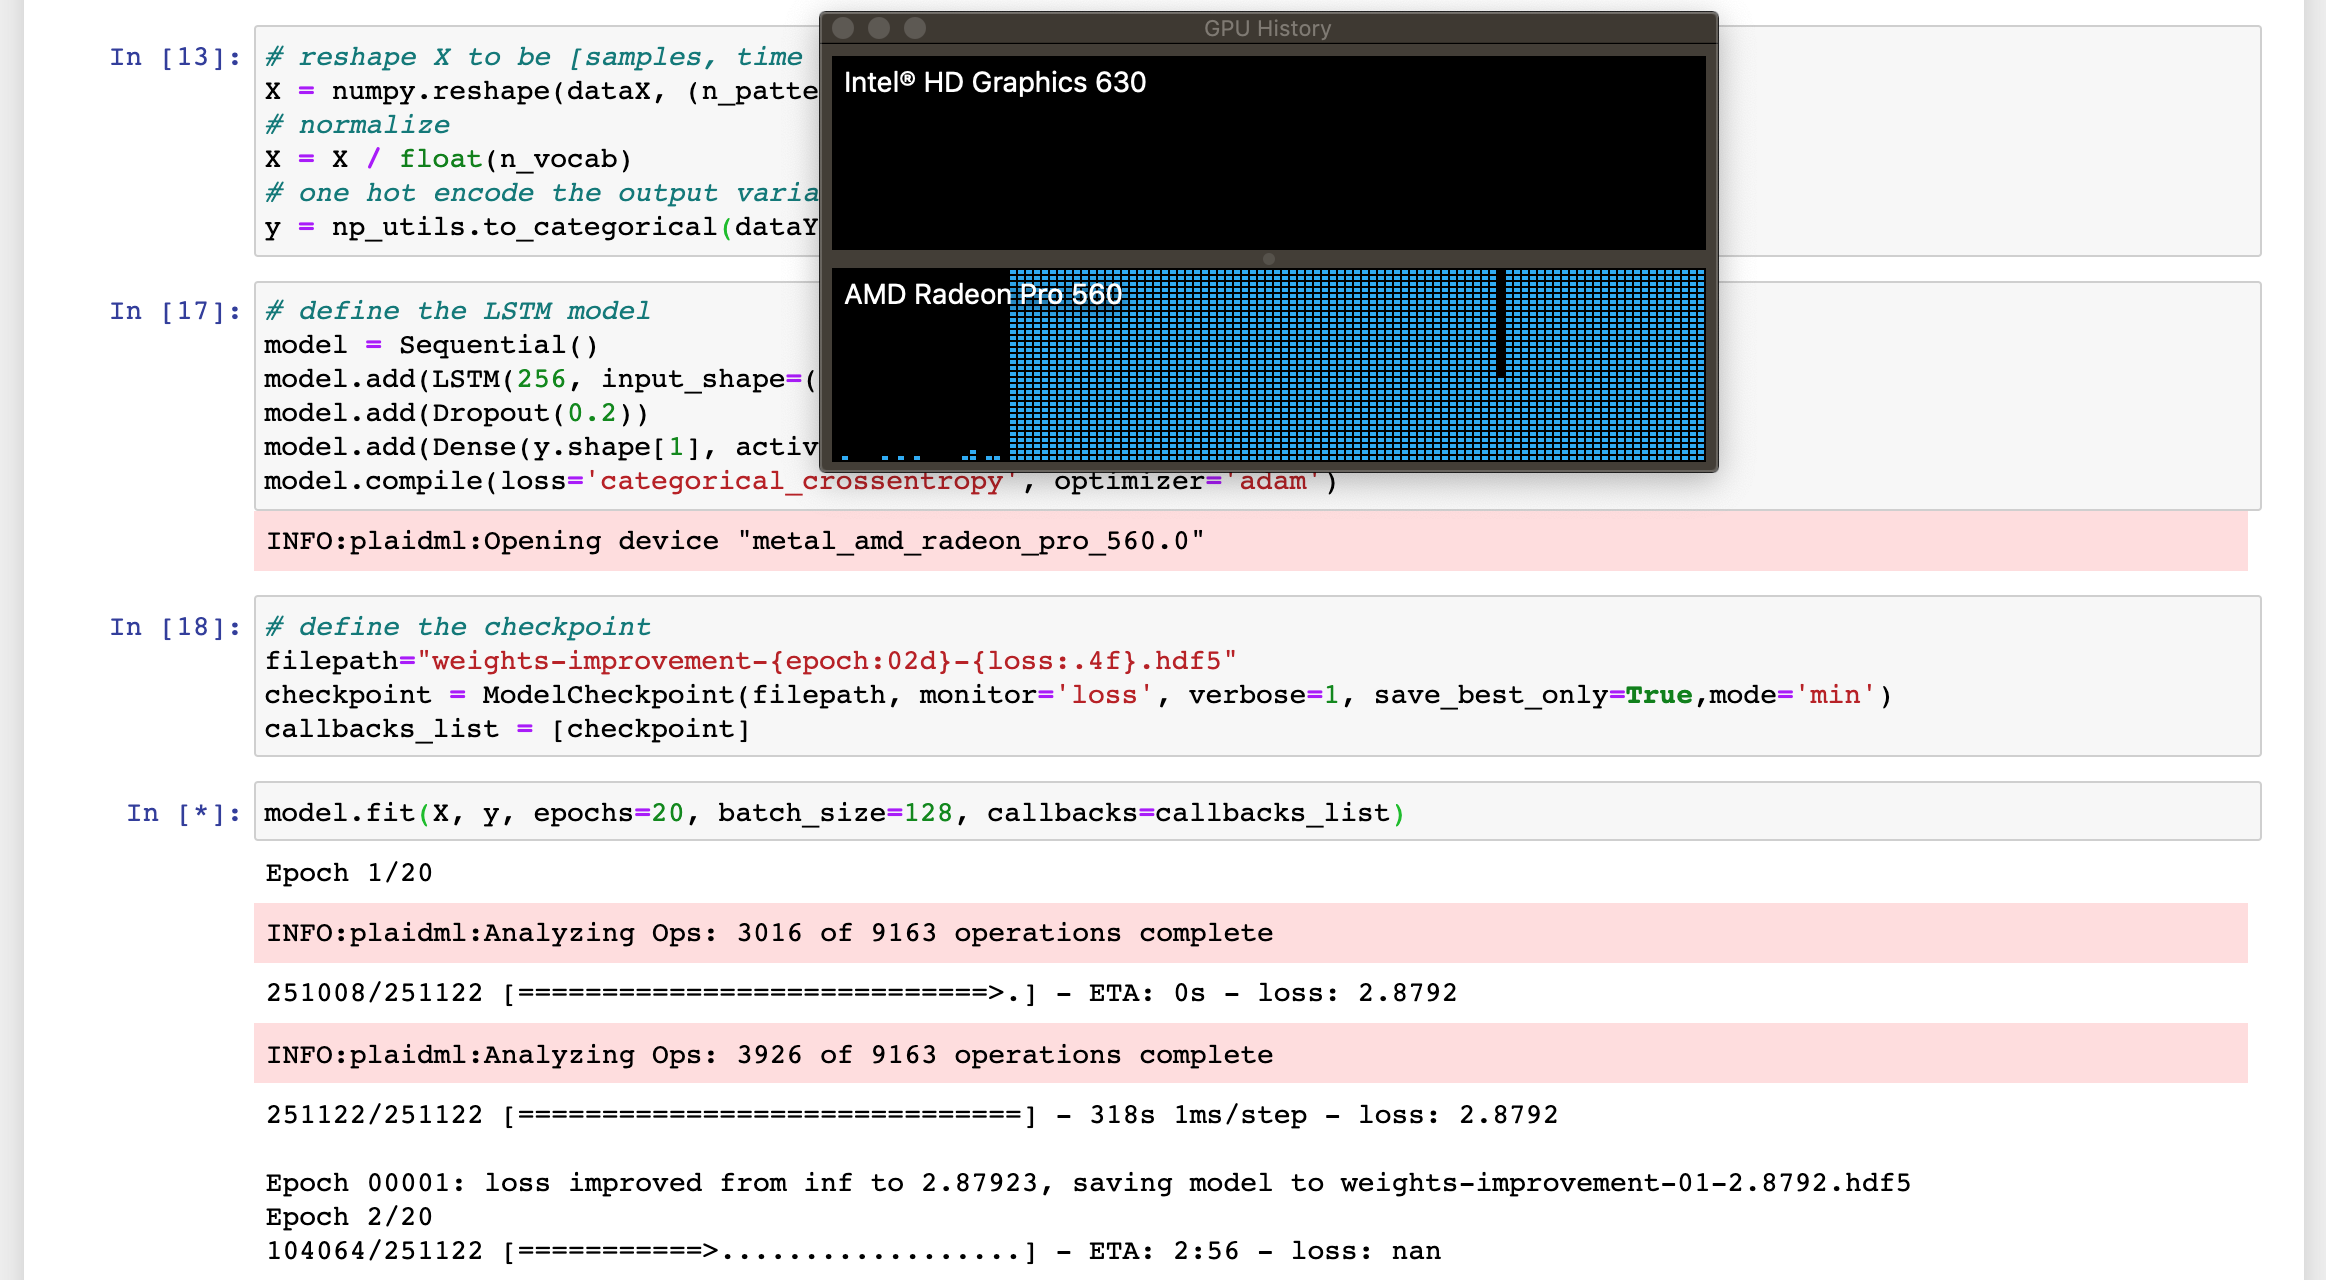



Literature: Deep Learning With Python
© Copyright 2019 Jason Brownlee. All Rights Reserved. Edition: v1.18